In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score

from sequential_ft_transformer.fttransformer import FTTransformer
from sequential_ft_transformer.preprocessing import sq_df_to_dataset, download_data
from sequential_ft_transformer.plotting import plot_importances, plot_training_hist


2024-10-03 21:01:12.340303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 21:01:12.371527: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 21:01:12.387111: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-03 21:01:13.273046: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Download Data

In [2]:
data_folder = "../data/"
seq_length = 1

In [3]:
CSV_HEADER = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital_status",
    "occupation",
    "relationship",
    "race",
    "gender",
    "capital_gain",
    "capital_loss",
    "hours_per_week",
    "native_country",
    "income_bracket",
]

train_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

download_data(train_data_url, data_folder, "adult_train.csv")
download_data(test_data_url, data_folder, "adult_test.csv")

train_data = pd.read_csv(os.path.join(data_folder, "adult_train.csv"), header=None, names=CSV_HEADER)
test_data = pd.read_csv(os.path.join(data_folder, "adult_test.csv"), header=None, names=CSV_HEADER)

print(f"Train dataset shape: {train_data.shape}")
print(f"Test dataset shape: {test_data.shape}")

adult_train.csv already exists in ../data/
adult_test.csv already exists in ../data/
Train dataset shape: (32561, 15)
Test dataset shape: (16282, 15)


In [4]:
train_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Preprocess

In [5]:
# Column information
NUMERIC_FEATURES = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
NUMERIC_FEATURES = sorted(NUMERIC_FEATURES)
CATEGORICAL_FEATURES = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'gender', 'native_country']
CATEGORICAL_FEATURES = sorted(CATEGORICAL_FEATURES)

FEATURES = sorted(list(NUMERIC_FEATURES) + list(CATEGORICAL_FEATURES))
LABEL = 'income_bracket'

In [6]:
# encoding as binary target
train_data[LABEL] = train_data[LABEL].apply(lambda x: int(x == ' >50K')) 
test_data[LABEL] = test_data[LABEL].apply(lambda x: int(x == ' >50K.'))

In [7]:
train_data = train_data.dropna()
test_data = test_data.dropna()

In [8]:
train_input = train_data[FEATURES]
train_labels = train_data[LABEL]

test_input = test_data[FEATURES]
test_labels = test_data[LABEL]

## Get Lookup Tables for Each Categorical Column

In [9]:
cat_lookups = dict()
feature_unique_counts = dict()
num_oov_indices = 1
for cat in CATEGORICAL_FEATURES:
    unique_values = list(np.unique(train_input[cat]).astype(str))
    feature_unique_counts[cat] = len(unique_values) + num_oov_indices
    lookup = keras.layers.StringLookup(vocabulary=unique_values, num_oov_indices=num_oov_indices)
    cat_lookups[cat] = lookup

I0000 00:00:1727982074.130908  567174 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-03 21:01:14.264101: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Convert Each Categorical String to an ID

In [10]:
for cat in CATEGORICAL_FEATURES:
    train_input.loc[: , cat] = cat_lookups[cat](train_input[cat])
    test_input.loc[: , cat] = cat_lookups[cat](test_input[cat])

In [11]:
train_input.loc[:, CATEGORICAL_FEATURES] = train_input[CATEGORICAL_FEATURES].astype("category")
test_input.loc[:, CATEGORICAL_FEATURES] = test_input[CATEGORICAL_FEATURES].astype("category")

train_input.loc[:, NUMERIC_FEATURES] = train_input[NUMERIC_FEATURES].astype(float)
test_input.loc[:, NUMERIC_FEATURES] = test_input[NUMERIC_FEATURES].astype(float)

In [12]:
train_labels = train_labels.to_frame(name=LABEL)
test_labels = test_labels.to_frame(name=LABEL)

In [13]:
x_train, x_val, y_train, y_val = train_test_split(train_input, train_labels, test_size=0.2)

## Create TF Datasets

In [14]:
batch_size = 1000
train_dataset = sq_df_to_dataset(
    x_train, 
    seq_length, 
    target_df=y_train, 
    target=LABEL, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    batch_size=batch_size
)
val_dataset = sq_df_to_dataset(
    x_val, 
    seq_length, 
    target_df=y_val, 
    target=LABEL, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    shuffle=False, # No shuffle
    batch_size=batch_size
)  
test_dataset = sq_df_to_dataset(
    test_input, 
    seq_length, 
    categorical_features=CATEGORICAL_FEATURES, 
    numerical_features=NUMERIC_FEATURES, 
    shuffle=False, 
    batch_size=batch_size) # No target, no shuffle

## Create bins for PLE

## Target-Aware Bins

In [15]:
from sklearn.tree import DecisionTreeClassifier

N_BINS = 10

t_bins_dict = dict()
for feature in NUMERIC_FEATURES:
    data = x_train[feature].values.reshape(-1, 1)
    y = y_train[LABEL].values

    dt = DecisionTreeClassifier(max_leaf_nodes=N_BINS)
    dt.fit(data, y)
    bins = np.unique(dt.tree_.threshold).astype("float32")
    t_bins_dict[feature] = bins

In [16]:
t_bins_dict

{'age': array([-2. , 23.5, 25.5, 28.5, 29.5, 35.5, 43.5, 54.5, 61.5, 69.5],
       dtype=float32),
 'capital_gain': array([-2.0000e+00,  5.7000e+01,  3.0480e+03,  3.1200e+03,  4.2435e+03,
         4.4010e+03,  5.1190e+03,  5.3165e+03,  6.6185e+03,  7.0735e+03],
       dtype=float32),
 'capital_loss': array([-2.0000e+00,  1.5515e+03,  1.5685e+03,  1.8205e+03,  1.8620e+03,
         1.8815e+03,  1.9785e+03,  2.1685e+03,  2.1765e+03,  2.3580e+03],
       dtype=float32),
 'education_num': array([-2. ,  1.5,  6.5,  7.5,  8.5,  9.5, 10.5, 12.5, 13.5, 14.5],
       dtype=float32),
 'hours_per_week': array([-2. ,  2.5, 34.5, 39.5, 41.5, 46.5, 49.5, 50.5, 54.5, 65.5],
       dtype=float32)}

## Quantile Bins

In [17]:
N_BINS = 10

interval = 1 / N_BINS
intervals = np.arange(0.0, 1 + interval, interval)

q_bins_dict = dict()
for feature in NUMERIC_FEATURES:
    data = x_train[feature]

    bins = np.quantile(np.unique(data.values), intervals)
    q_bins_dict[feature] = bins

In [18]:
q_bins_dict

{'age': array([17. , 24.1, 31.2, 38.3, 45.4, 52.5, 59.6, 66.7, 73.8, 80.9, 90. ]),
 'capital_gain': array([    0. ,  1418. ,  2070.6,  2412.6,  2962.2,  3464. ,  4471.2,
         5796.2,  7639. , 14614.4, 99999. ]),
 'capital_loss': array([   0.,  974., 1504., 1628., 1735., 1876., 2042., 2201., 2339.,
        2547., 4356.]),
 'education_num': array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ]),
 'hours_per_week': array([ 1. , 10.3, 19.6, 28.9, 38.2, 47.5, 56.8, 66.1, 77.4, 88.7, 99. ])}

## Target-Aware PLE Numerical Embedding FT-Transformer

In [19]:
EXPLANATIONS = True 
LEARNING_RATE = 0.0005
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 10

In [20]:
model = FTTransformer(
    out_dim=1,
    out_activation='sigmoid',
    feature_unique_counts=feature_unique_counts,
    numerical_features=NUMERIC_FEATURES,
    categorical_features=CATEGORICAL_FEATURES,
    seq_length=seq_length,
    numerical_embedding_type='ple',
    bins_dict=t_bins_dict,
    explainable=EXPLANATIONS    
)

optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

loss = keras.losses.BinaryCrossentropy()
metrics = [keras.metrics.AUC(name="PR AUC", curve='PR')]
if EXPLANATIONS:
    metrics.append(None)
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)

early = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=20, restore_best_weights=True)
callback_list = [early]

/home/ubuntu22/repos/sequential-ft-transformer/venv_keras35/lib/python3.10/site-packages/keras/src/models/functional.py:106: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'cat_inputs' mapping to value <KerasTensor shape=(None, 1, 8), dtype=float32, sparse=False, name=keras_tensor> which has name 'keras_tensor'. Change the tensor name to 'cat_inputs' (via `Input(..., name='cat_inputs')`)
  warnings.warn(
/home/ubuntu22/repos/sequential-ft-transformer/venv_keras35/lib/python3.10/site-packages/keras/src/models/functional.py:106: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'numeric_inputs' mapping to value <KerasTensor shape=(None, 1, 5), dtype=float32, sparse=False, name=keras_tensor_1> which has name 'keras_tensor_1'. Change the tensor name to 'numeric_inputs' (via `Input(..., name='numeric_inputs')`)
  warnings.wa

In [21]:
hist = model.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 699ms/step - loss: 0.5432 - output_PR AUC: 0.3204 - val_loss: 0.4223 - val_output_PR AUC: 0.6014
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.3720 - output_PR AUC: 0.6731 - val_loss: 0.3982 - val_output_PR AUC: 0.6398
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3571 - output_PR AUC: 0.7396 - val_loss: 0.4490 - val_output_PR AUC: 0.6422
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3391 - output_PR AUC: 0.7588 - val_loss: 0.4296 - val_output_PR AUC: 0.6567
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3282 - output_PR AUC: 0.7660 - val_loss: 0.4048 - val_output_PR AUC: 0.6610
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3274 - output_PR AUC: 0.7660 - val_loss: 0.3701 - val_output_PR AUC: 0.6765
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3120 - output_PR AUC: 0.7869 - val_loss: 0.4308 - val_output_PR AUC: 0.6638
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0

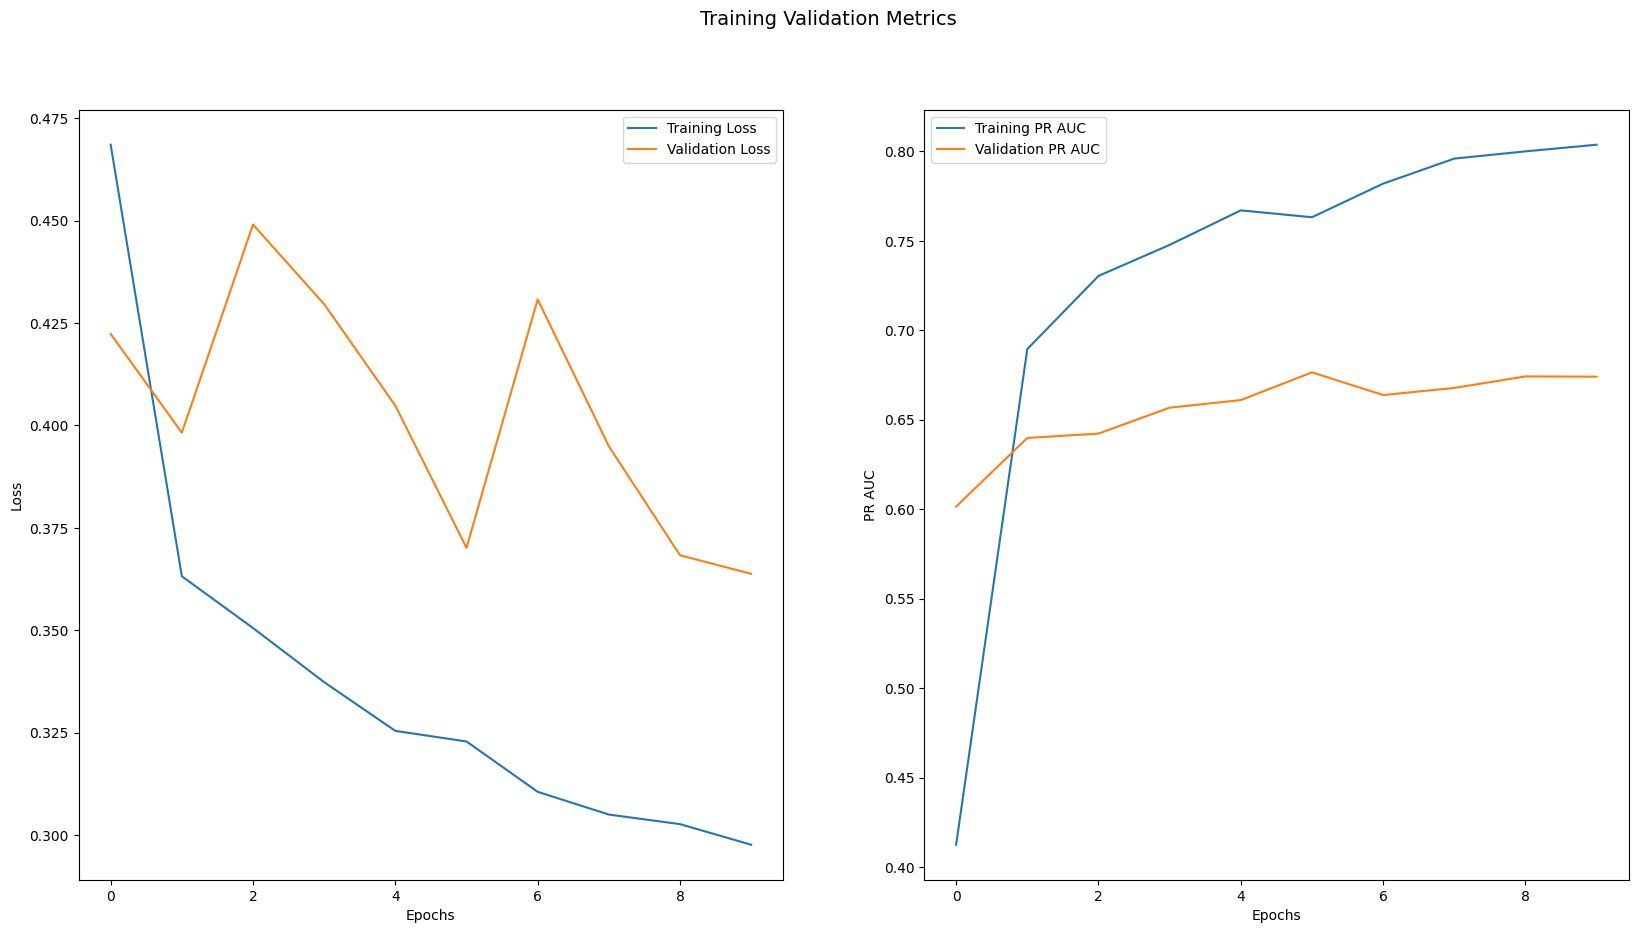

In [22]:
hist_plot = plot_training_hist(hist.history, EXPLANATIONS)

In [23]:
preds = model.predict(test_dataset)
# Two outputs are provided when explainability is requested
if len(preds) == 2:
    flat_preds = preds[0].ravel()
else:
    flat_preds = preds.ravel()
print("Test ROC AUC:", np.round(roc_auc_score(test_data[LABEL], flat_preds), 4))
print("Test PR AUC:", np.round(average_precision_score(test_data[LABEL], flat_preds), 4))
print("Test Accuracy:", np.round(accuracy_score(test_data[LABEL], flat_preds > 0.5), 4))

# Reported accuracy - 0.858

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step
Test ROC AUC: 0.8339
Test PR AUC: 0.5351
Test Accuracy: 0.7756


## Explainability

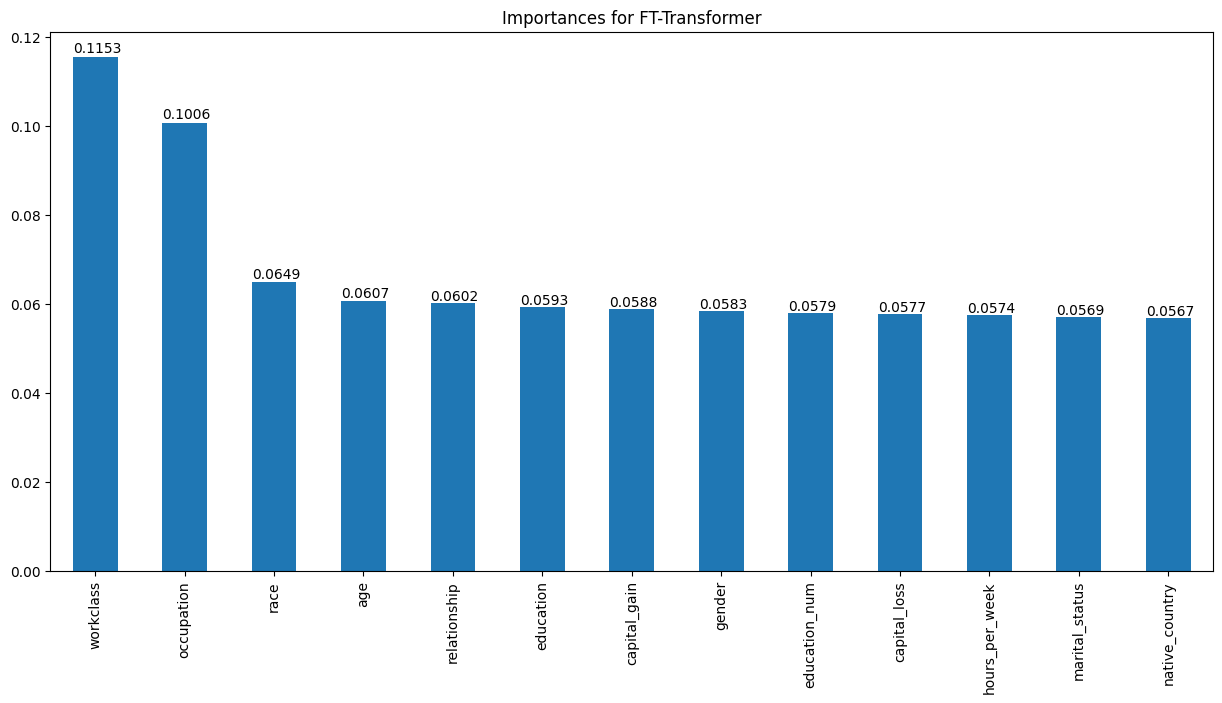

In [24]:
# Two outputs are provided when explainability is requested
if len(preds) == 2:
    importances = preds[1]
    importances_df = pd.DataFrame(importances[:, :-1], columns = FEATURES)
    importances_fig, total_importances = plot_importances(
        importances_df, 
        title="Importances for FT-Transformer"
    )

## Quantile PLE Transformer

In [25]:
model = FTTransformer(
    out_dim=1,
    out_activation='sigmoid',
    feature_unique_counts=feature_unique_counts,
    numerical_features=NUMERIC_FEATURES,
    categorical_features=CATEGORICAL_FEATURES,
    seq_length=seq_length,
    numerical_embedding_type='ple',
    bins_dict=q_bins_dict,
    explainable=EXPLANATIONS    
)

optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

loss = keras.losses.BinaryCrossentropy()
metrics = [keras.metrics.AUC(name="PR AUC", curve='PR')]
if EXPLANATIONS:
    metrics.append(None)
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics,
)

early = keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=20, restore_best_weights=True)
callback_list = [early]

/home/ubuntu22/repos/sequential-ft-transformer/venv_keras35/lib/python3.10/site-packages/keras/src/models/functional.py:106: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'cat_inputs' mapping to value <KerasTensor shape=(None, 1, 8), dtype=float32, sparse=False, name=keras_tensor_42> which has name 'keras_tensor_42'. Change the tensor name to 'cat_inputs' (via `Input(..., name='cat_inputs')`)
  warnings.warn(
/home/ubuntu22/repos/sequential-ft-transformer/venv_keras35/lib/python3.10/site-packages/keras/src/models/functional.py:106: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'numeric_inputs' mapping to value <KerasTensor shape=(None, 1, 5), dtype=float32, sparse=False, name=keras_tensor_43> which has name 'keras_tensor_43'. Change the tensor name to 'numeric_inputs' (via `Input(..., name='numeric_inputs')`)
  war

In [26]:
hist = model.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 611ms/step - loss: 0.4511 - output_PR AUC: 0.5321 - val_loss: 0.4006 - val_output_PR AUC: 0.6225
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.3558 - output_PR AUC: 0.7111 - val_loss: 0.4057 - val_output_PR AUC: 0.6643
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3271 - output_PR AUC: 0.7509 - val_loss: 0.5412 - val_output_PR AUC: 0.6703
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3209 - output_PR AUC: 0.7526 - val_loss: 0.4491 - val_output_PR AUC: 0.6779
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3254 - output_PR AUC: 0.7622 - val_loss: 0.4303 - val_output_PR AUC: 0.6903
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3264 - output_PR AUC: 0.7651 - val_loss: 0.4584 - val_output_PR AUC: 0.6813
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3080 - output_PR AUC: 0.7822 - val_loss: 0.3893 - val_output_PR AUC: 0.6873
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0

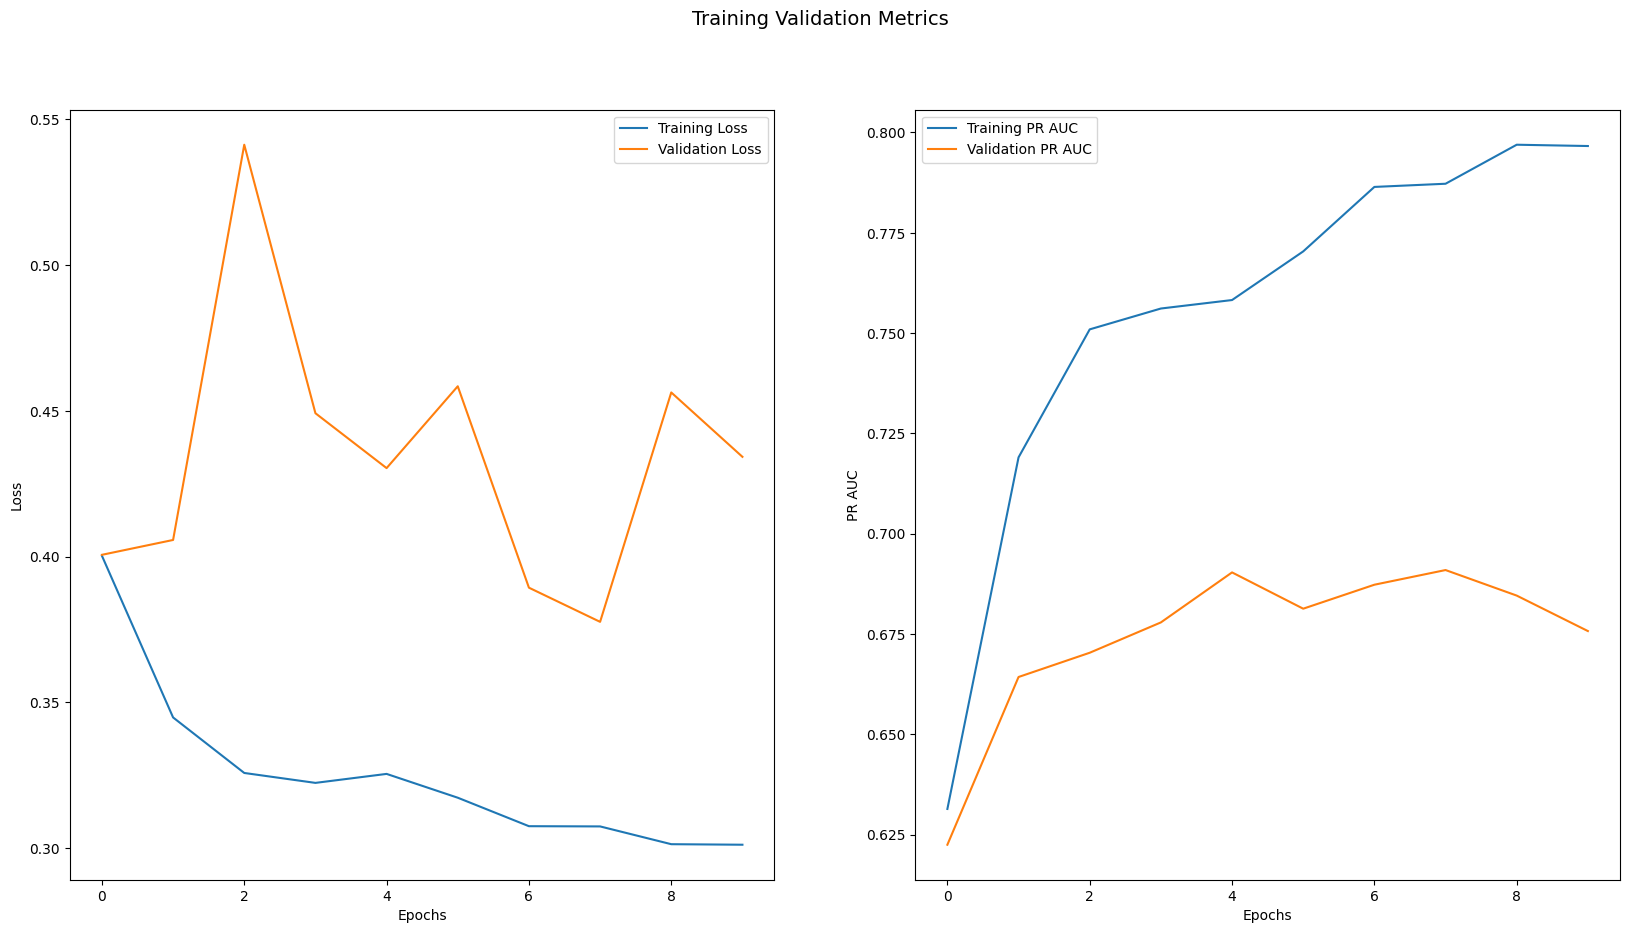

In [27]:
hist_plot = plot_training_hist(hist.history, EXPLANATIONS)

In [28]:
preds = model.predict(test_dataset)
# Two outputs are provided when explainability is requested
if len(preds) == 2:
    flat_preds = preds[0].ravel()
else:
    flat_preds = preds.ravel()
print("Test ROC AUC:", np.round(roc_auc_score(test_data[LABEL], flat_preds), 4))
print("Test PR AUC:", np.round(average_precision_score(test_data[LABEL], flat_preds), 4))
print("Test Accuracy:", np.round(accuracy_score(test_data[LABEL], flat_preds > 0.5), 4))

# Reported accuracy - 0.858

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step
Test ROC AUC: 0.8665
Test PR AUC: 0.6363
Test Accuracy: 0.8208


## Explainability

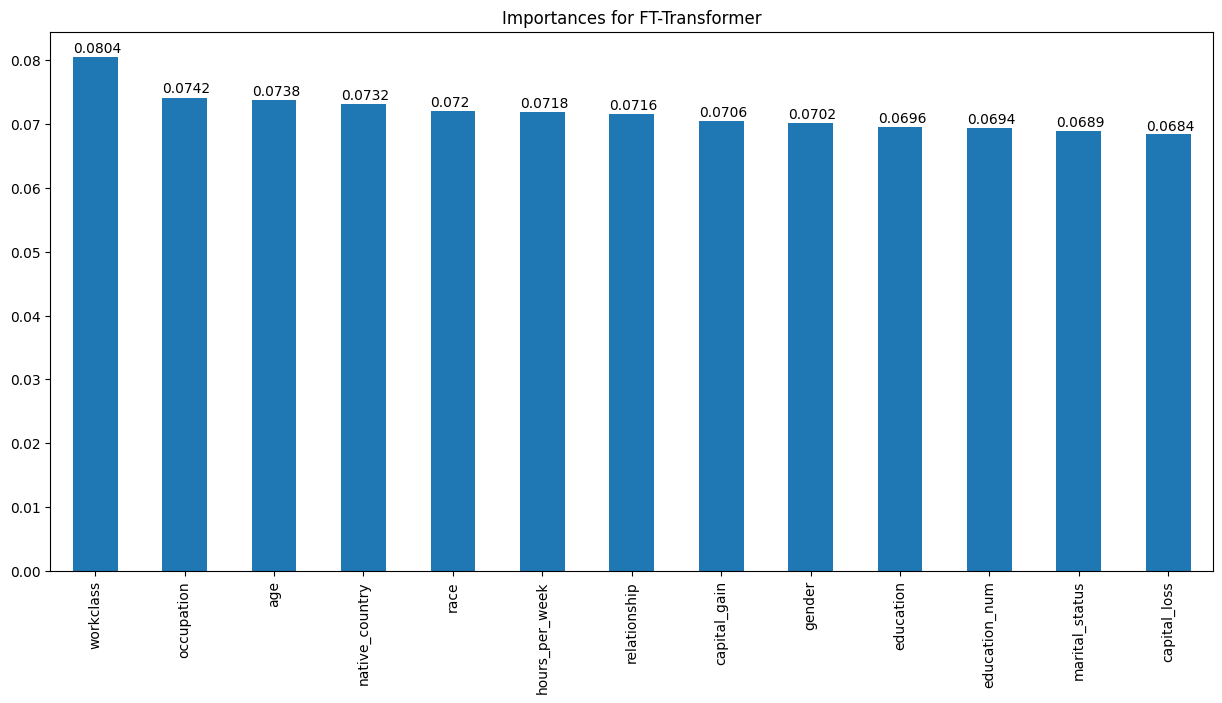

In [29]:
# Two outputs are provided when explainability is requested
if len(preds) == 2:
    importances = preds[1]
    importances_df = pd.DataFrame(importances[:, :-1], columns = FEATURES)
    importances_fig, total_importances = plot_importances(
        importances_df, 
        title="Importances for FT-Transformer"
    )